In [1]:
import random
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split

from torch.utils.data.dataset import Dataset

import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
np.random.seed(1)
random.seed(1)

data = np.load('data/RESISC45_images_256.npy')
labels = np.load('data/RESISC45_classes.npy')

test_size = 0.25
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size = test_size, stratify = labels)


np.save('data/RESISC45_images_train.npy', xtrain)
np.save('data/RESISC45_labels_train.npy', ytrain)
np.save('data/RESISC45_images_test.npy', xtest)
np.save('data/RESISC45_labels_test.npy', ytest)


In [3]:
train_data = np.load('data/RESISC45_images_train.npy')
train_labels = np.load('data/RESISC45_labels_train.npy')
classes = np.load('data/RESISC45_class_names.npy')

print('Training data shape: ', train_data.shape)
print('Testing data shape: ', train_labels.shape)
print('Num Classes', classes.shape)

Training data shape:  (23625, 256, 256, 3)
Testing data shape:  (23625,)
Num Classes (45,)


In [4]:
img_size = train_data.shape[2]# can use this to mofidy data size to fit this model (which only takes 256 images)

bs = 32 # 64

c_dim = classes.shape[0]

print(img_size)

256


In [5]:
xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size = 0.25)

xtrain = torch.tensor(xtrain).permute(0,3,1,2)
print(torch.min(xtrain), torch.max(xtrain))

trainset = []
for i in range(xtrain.shape[0]):
    trainset.append((xtrain[i], ytrain[i]))
    
train_loader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=False) #BUG: must keep shuffle false - or else it screws up labels, apparently

## Validation Data
valset = []
xval = torch.tensor(xval).permute(0,3,1,2)

print(torch.min(xval), torch.max(xval))
for i in range(xval.shape[0]):
    valset.append((xval[i], yval[i]))

val_loader = torch.utils.data.DataLoader(valset, batch_size=64, drop_last = True,
                                          shuffle=False) #BUG: must keep shuffle false - or else it screws up labels, apparently

test_data = np.load('data/RESISC45_images_test.npy')
test_labels = np.load('data/RESISC45_labels_test.npy')

test_data = torch.tensor(test_data)
test_labels = torch.tensor(test_labels)
## Testing Data
testset = []
print(test_data.shape)
xtest = torch.tensor(test_data).permute(0,3,1,2)
print(xtest.shape)

print(torch.min(test_data), torch.max(test_data))
for i in range(test_data.shape[0]):
    testset.append((test_data[i], test_labels[i]))

test_loader = torch.utils.data.DataLoader(testset, batch_size=64, drop_last = True,
                                          shuffle=False) #BUG: must keep shuffle false - or else it screws up labels, apparently



tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
torch.Size([7875, 256, 256, 3])


<ipython-input-5-c44b232db32c>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtest = torch.tensor(test_data).permute(0,3,1,2)


torch.Size([7875, 3, 256, 256])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


Shape of a batch of images:
torch.Size([32, 3, 256, 256])
Shape of a batch of labels:
torch.Size([32])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
17
harbor


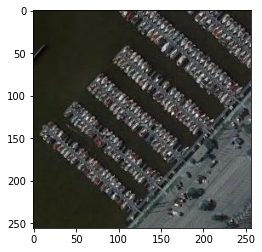

In [6]:
print('Shape of a batch of images:')
print(next(iter(train_loader))[0].shape)
print('Shape of a batch of labels:')
print(next(iter(train_loader))[1].shape)

first_samp = next(iter(train_loader))[0][0] #get first sample in first batch
print(torch.min(first_samp), torch.max(first_samp)) #images naturally (0,255)
plt.imshow(first_samp.permute(1,2,0)/255) #show it

name = next(iter(train_loader))[1][0].data.item()
print(name)
print(classes[name]) 

In [7]:
class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        ## Encoding: Unconditional samples
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # Input: (bs, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, 4, 2, 1, bias = False)
        self.conv7_bn = nn.BatchNorm2d(512)
        
        #self.conv7 = nn.Conv2d(2048, z_dim, 4, 2, 0) # Output: (bs, c_dim, 1, 1)
        self.fce = nn.Linear(512*2*2, 45)

    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        # Encode data x to 2 spaces: condition space and variance-space
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.conv7_bn(self.conv7(x)))
        
        #print(x.shape, self.fce.weight.shape)
        x = x.reshape(x.shape[0], -1)
        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))

        return z


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        #m.bias.data.zero_()

def one_hot_embedding(labels):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = c_dim)
    return torch.squeeze(labels)

def top_k_acc(inp, targ, k):
    #print(inp.shape)
    tops = torch.topk(inp, k=k, dim = 1)
    
    i = 0
    corrects = 0
    for row in tops:
        for element in row:
            if element == targ[i]:
                corrects += 1
            
        i+=1
        
    return corrects / inp.shape[0]

def accuracy_topk(output, target, topk=(3,)):
    #https://forums.fast.ai/t/return-top-k-accuracy/27658
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

In [8]:
CNN = Conv_Pred()
CNN.weight_init()
CNN.to(device)

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
learning_rate = 0.0016

augmentations = True

CNN_optimizer = optim.Adam(CNN.parameters(),
                         lr = learning_rate)
                         #betas = (beta_1, beta_2))
    
augmentation_list = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomPerspective(distortion_scale=0.05, p=0.7, fill=0.2),
        transforms.RandomAffine(180),
        #transforms.RandomResizedCrop(img_size),
        transforms.ColorJitter(saturation=0.1, hue=0.02)
        #transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ])

In [9]:
CNN_loss_tracker = []
val_accs, val_topks = [], []
n_epochs = 100 # 25+ needed. just keep raising this number...
print_stride = n_epochs // 5

for epoch in range(1, n_epochs+1):

    CNN_losses = []

    for X, y in train_loader:
        #print(torch.min(X), torch.max(X))
        mini_batch = X.size()[0]
        X = X.to(device).float()
        X = 2.0*(X/255 - 0.5)
        y = one_hot_embedding(y.to(device)).float()
        
        if augmentations == True:
            X = augmentation_list(X)

        ## CNN Training
        for param in CNN.parameters():
            param.grad = None

        yhat = CNN(X)
        #print(yhat, y)
        pred_loss = bce_loss(yhat, y)
        
        model_loss = pred_loss
        #print(model_loss)

        model_loss.backward()
        CNN_optimizer.step()

        CNN_losses.append(pred_loss.data.item())
        
    
    if epoch % print_stride == 0:
        print('Epoch {} - loss_CNN: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(CNN_losses))))

        CNN_loss_tracker.append(torch.mean(torch.FloatTensor(CNN_losses)))
        
        with torch.no_grad():
            accs, actk = [], []
            for x, y in val_loader:
                x, y = x.to(device).float(), y.to(device).float()
                #print(x, y)
                yhat = CNN(x)
                
                yhat_max = torch.max(yhat, dim = 1)[1]
                #print(yhat.shape)
                
                correct = torch.sum(yhat_max == y)
                size = x.shape[0]
                
                acc_topk = accuracy_topk(yhat, y)
                #print(acc_topk)
                actk.append(acc_topk.data.item())
                
                accs.append(100*(correct/size).data.item())
            print()
            print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
            print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
            print()
            
        val_accs.append(torch.mean(torch.FloatTensor(accs)))
        val_topks.append(torch.mean(torch.FloatTensor(actk)))


<ipython-input-7-6ca46aa157fc>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = c_dim)
C:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Epoch 20 - loss_CNN: 0.036

Validation Accuracy:  30.349864959716797
Validation Top3 Accuracy:  52.105979919433594

Epoch 40 - loss_CNN: 0.034

Validation Accuracy:  24.881114959716797
Validation Top3 Accuracy:  43.189537048339844

Epoch 60 - loss_CNN: 1.607

Validation Accuracy:  4.73845100402832
Validation Top3 Accuracy:  11.61684799194336

Epoch 80 - loss_CNN: 1.497

Validation Accuracy:  5.7404890060424805
Validation Top3 Accuracy:  12.245244979858398

Epoch 100 - loss_CNN: 4.344

Validation Accuracy:  2.3607337474823
Validation Top3 Accuracy:  7.28600549697876



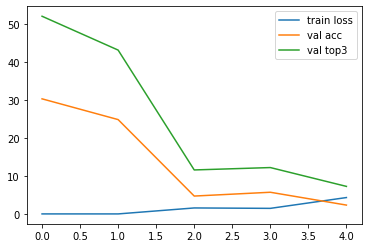

In [10]:
plt.plot(CNN_loss_tracker, label = 'train loss')
plt.plot(val_accs, label = 'val acc')
plt.plot(val_topks, label = 'val top3')
plt.legend(loc = 'best')
plt.show()

In [11]:
with torch.no_grad():
    accs, topks = [], []
    for x, y in test_loader:
        x, y = x.permute(0,3,1,2).to(device).float(), y.to(device).float()
        #print(x, y)
        yhat = CNN(x)

        yhat_max = torch.max(yhat, dim = 1)[1]
        #print(yhat.shape)

        correct = torch.sum(yhat_max == y)
        size = x.shape[0]
        acc_topk = accuracy_topk(yhat, y)
        actk.append(acc_topk.data.item())
                
        accs.append(100*(correct/size).data.item())
        topks.append(actk)

    print('Test Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
    print('Test Top3 Accuracy: ', torch.mean(torch.FloatTensor(topks)).data.item())

Test Accuracy:  2.223069190979004
Test Top3 Accuracy:  6.860465049743652
